# <center> **Brief Brest**

[Brief Time series - Sujet du Brief 2025.docx](<Brief Time series - Sujet du Brief 2025 nouvelle version.docx>)

**Remarque** : Notebook to run in environnement "time_series"

### **Sources**

**Times Series**<br>
https://datascientest.com/series-temporelles-python<br>
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/<br>

**Statsmodels**<br>
https://www.statsmodels.org/stable/index.html<br>

**Test de Dickey-Fuller**<br>
https://fr.wikipedia.org/wiki/Test_de_Dickey-Fuller<br>

**ACF PACF**<br>
https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html#statsmodels.graphics.tsaplots.plot_acf<br>
https://www.geeksforgeeks.org/autocorrelation-and-partial-autocorrelation/<br>
https://support.minitab.com/fr-fr/minitab/help-and-how-to/statistical-modeling/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/<br>

**ARMA, ARIMA**<br>
https://medium.com/@kylejones_47003/time-series-analysis-with-statsmodels-in-python-ea0fce203c0a<br>
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3#step-5-<br>
https://www.kaggle.com/code/gauravduttakiit/forecasting-with-arma-method<br>
<br>

## **Imports**

In [491]:
import os
import math
import tqdm
import copy
import numpy as np
import pandas as pd
import warnings
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Scikit-Learn
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 10)

## **Préparation des données**

In [353]:
df_data = pd.read_csv('GlobalLandTemperaturesByCity.csv', delimiter = ',', low_memory=False)

In [167]:
df_data.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [357]:
df_france = df_data[df_data['Country'] == 'France'][df_data.columns[:4]]
df_brest = df_france[df_france['City'] == 'Brest'][df_france.columns[:3]]
print(df_brest.shape)
df_brest

(3239, 3)


,dt,AverageTemperature,AverageTemperatureUncertainty
1130388,1743-11-01,11.346,1.826
1130389,1743-12-01,NaN,NaN
1130390,1744-01-01,NaN,NaN
1130391,1744-02-01,NaN,NaN
1130392,1744-03-01,NaN,NaN
...,...,...,...
1133622,2013-05-01,10.140,0.491
1133623,2013-06-01,13.187,0.563
1133624,2013-07-01,17.862,0.739
1133625,2013-08-01,17.096,0.245


In [356]:
print(df_france.shape)

(116604, 4)


In [171]:
df_brest.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
dtype: object

### **Suppression des Nan**

In [359]:
df_france_notna = df_france.dropna()
df_brest_notna  = df_brest.dropna()
print(df_brest_notna.shape)
df_brest_notna.head()

(3166, 3)


,dt,AverageTemperature,AverageTemperatureUncertainty
1130388,1743-11-01,11.346,1.826
1130393,1744-04-01,9.802,2.184
1130394,1744-05-01,10.264,1.623
1130395,1744-06-01,13.310,1.640
1130396,1744-07-01,14.800,1.716


In [360]:
print(df_france_notna.shape)

(113976, 4)


### **Convert date to correct dateTime type**

They all are at the correct format 'yyyy-mm-dd' but in string type, we need to convert them into datetime to extract month, year ...

In [361]:
# Convert to datetime (it seems like it is already correct datetime format)
df_france_dt = df_france_notna.copy()
df_france_dt['dt'] = df_france_dt['dt'].apply(pd.to_datetime)

df_brest_dt = df_brest_notna.copy()
df_brest_dt['dt'] = df_brest_dt['dt'].apply(pd.to_datetime)

df_brest_dt.head()

,dt,AverageTemperature,AverageTemperatureUncertainty
1130388,1743-11-01,11.346,1.826
1130393,1744-04-01,9.802,2.184
1130394,1744-05-01,10.264,1.623
1130395,1744-06-01,13.310,1.640
1130396,1744-07-01,14.800,1.716


In [362]:
df_brest_dt.sort_values(by = ['dt'])
df_france_dt.sort_values(by = ['dt'])
df_brest_dt.head()

,dt,AverageTemperature,AverageTemperatureUncertainty
1130388,1743-11-01,11.346,1.826
1130393,1744-04-01,9.802,2.184
1130394,1744-05-01,10.264,1.623
1130395,1744-06-01,13.310,1.640
1130396,1744-07-01,14.800,1.716


In [363]:
df_france_dt['month'] = df_france_dt['dt'].apply(lambda x : x.month)
df_france_dt['year']  = df_france_dt['dt'].apply(lambda x : x.year)
df_brest_dt['month']  = df_brest_dt['dt'].apply(lambda x : x.month)
df_brest_dt['year']   = df_brest_dt['dt'].apply(lambda x : x.year)
df_brest_dt.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,month,year
1130388,1743-11-01,11.346,1.826,11,1743
1130393,1744-04-01,9.802,2.184,4,1744
1130394,1744-05-01,10.264,1.623,5,1744
1130395,1744-06-01,13.310,1.640,6,1744
1130396,1744-07-01,14.800,1.716,7,1744


In [ ]:
# group = df_brest_dt.groupby(['year']).agg({'year' : np.count_nonzero}) # Idem
group = df_brest_dt.groupby(['year']).agg({'year' : 'count'})
group

,year
year,
1743,1
1744,8
1745,4
1750,11
1751,8
...,...
2009,12
2010,12
2011,12


In [196]:
# List of years where we have all data (12 months)
indexes_years = group[group['year'] == 12].index
print(len(indexes_years))
indexes_years

260


Index([1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762,
       ...
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012],
      dtype='int64', name='year', length=260)

In [367]:
# We only keep the data where we have 12 months of temperatures
# from 1753 until 2012 (we could keep only after 1800)

# df_ok = df_brest_dt[df_brest_dt['year'].isin(indexes_years)]
df_ok = df_brest_dt[df_brest_dt['year'] >= 1800]
df_ok

,dt,AverageTemperature,AverageTemperatureUncertainty,month,year
1131062,1800-01-01,8.654,2.211,1,1800
1131063,1800-02-01,6.434,4.853,2,1800
1131064,1800-03-01,6.821,4.320,3,1800
1131065,1800-04-01,10.056,2.346,4,1800
1131066,1800-05-01,11.919,1.582,5,1800
...,...,...,...,...,...
1133621,2013-04-01,8.664,0.659,4,2013
1133622,2013-05-01,10.140,0.491,5,2013
1133623,2013-06-01,13.187,0.563,6,2013
1133624,2013-07-01,17.862,0.739,7,2013


In [370]:
12*213 + 8 == 2564

True

In [371]:
df_ok = df_ok.set_index('dt')
df_ok

,AverageTemperature,AverageTemperatureUncertainty,month,year
dt,,,,
1800-01-01,8.654,2.211,1,1800
1800-02-01,6.434,4.853,2,1800
1800-03-01,6.821,4.320,3,1800
1800-04-01,10.056,2.346,4,1800
1800-05-01,11.919,1.582,5,1800
...,...,...,...,...
2013-04-01,8.664,0.659,4,2013
2013-05-01,10.140,0.491,5,2013
2013-06-01,13.187,0.563,6,2013


## **Analyse de la cohérence des données**

<Axes: xlabel='dt'>

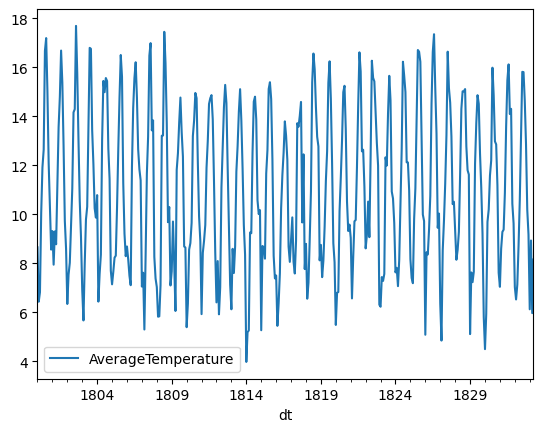

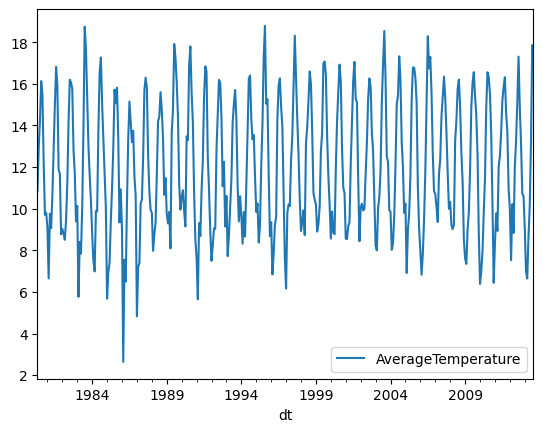

In [372]:
df_ok[:400].plot(y='AverageTemperature', kind='line')
df_ok[-400:].plot(y='AverageTemperature', kind='line')

<Axes: xlabel='dt'>

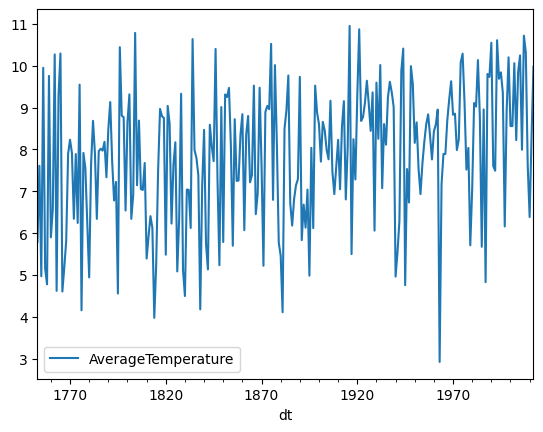

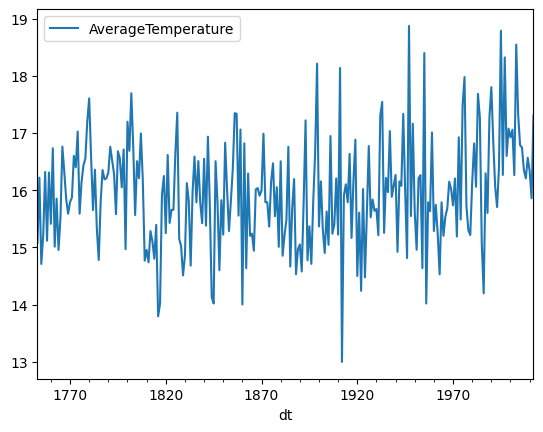

In [348]:
df_ok[::12].plot(y='AverageTemperature', kind='line')
df_ok[7::12].plot(y='AverageTemperature', kind='line')

### **Recherche de stationnarité dans les données**


Nous utilisons le test de Dickey-Fuller de la librairie **Statsmodels**, ce test permet de déterminer si une série temporelle est stationnaire, c'est-à-dire si ses propriétés statistiques (espérance, variance, auto-corrélation) varie dans le temps.

https://fr.wikipedia.org/wiki/Test_de_Dickey-Fuller<br>

Ici on peut considérer que **la série temporelle est stationnaire**, ce qui semble cohérent avec les données mesurées.

In [423]:
from statsmodels.tsa.stattools import adfuller

adf, pValue, _, _, _, _ = adfuller(df_ok['AverageTemperature'])
print("Coefficient ADF: ", adf)
print("La p-value du test de est de: ", pValue, "la série est donc stationnaire.")

Coefficient ADF:  -5.23547220909811
La p-value du test de est de:  7.438463367859367e-06 la série est donc stationnaire.


### **Recherche de saisonnalité**

**ACF** et **PACF** 

L'autocorrélation et l'autocorrélation partielle permettent de voir s'il y a une relation entre une série et ses valeurs décalées (translatées dans le temps).

https://www.geeksforgeeks.org/autocorrelation-and-partial-autocorrelation/

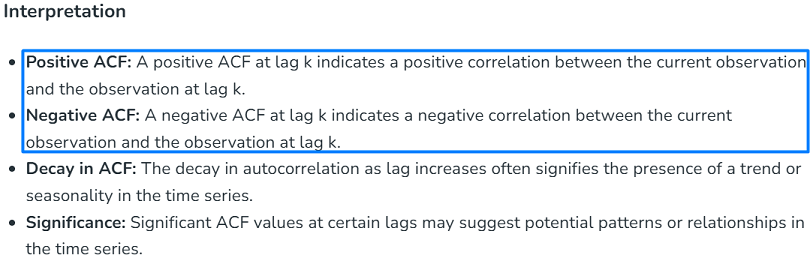

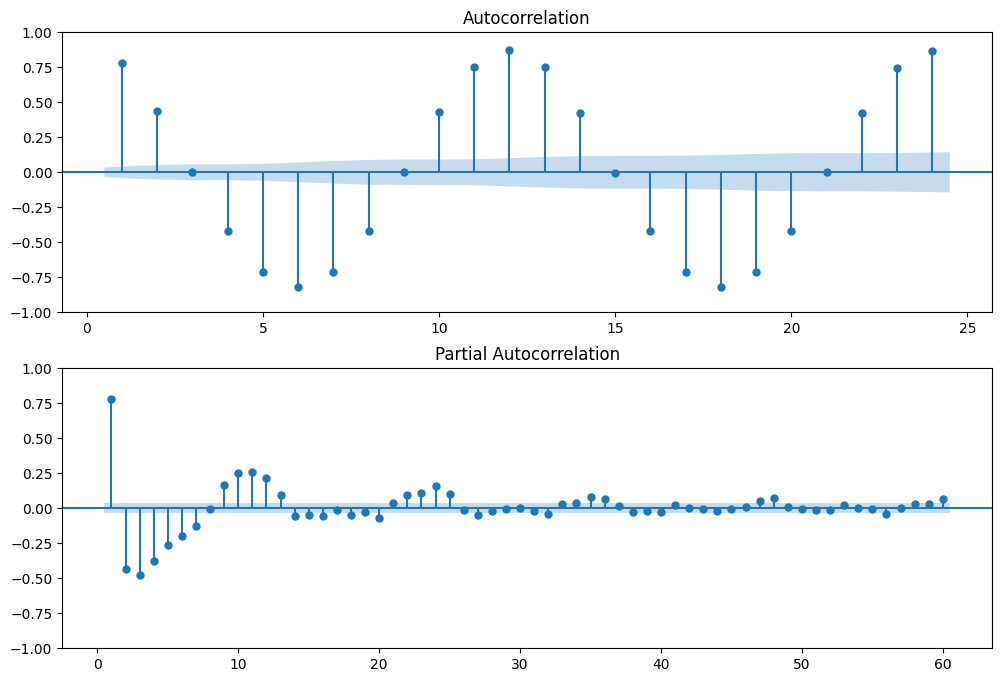

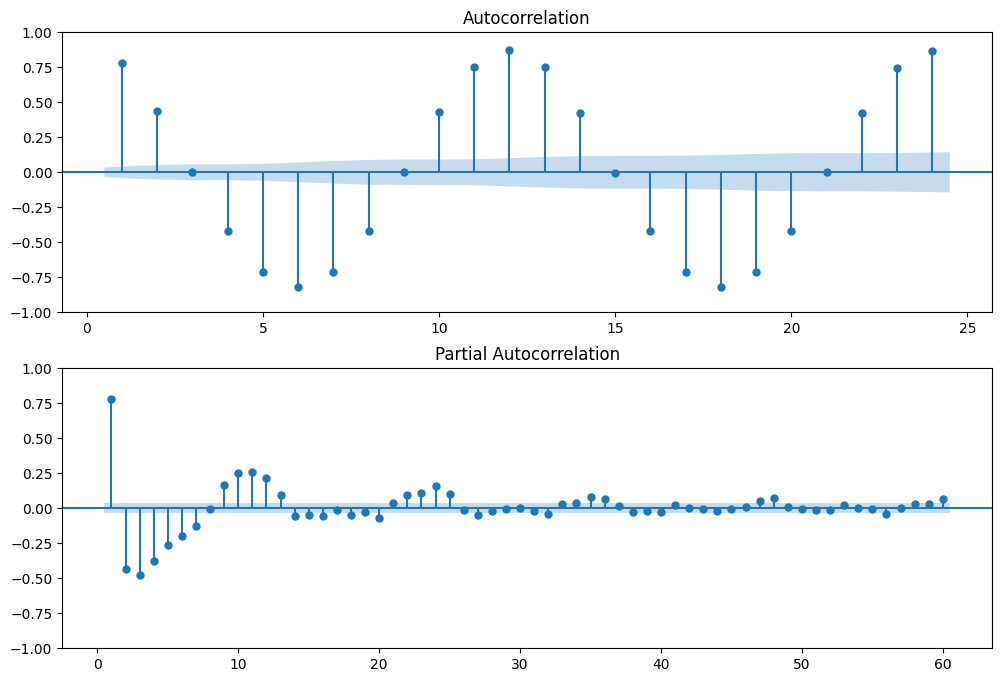

In [297]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(df_ok['AverageTemperature'],  lags=24, zero=False, ax=ax1)
plot_pacf(df_ok['AverageTemperature'], lags=60, zero=False, ax=ax2)

**Remarque** :

- On observe une corrélation très forte à périodicité de 12 mois et une corrélation fortement inverse à périodicité de 6 mois ce qui est cohérent.
- Est-ce que cette corrélation indique l'ordre q = 12 de la partie moyenne mobile ? (selon cet article oui [geeksforgeeks.org](https://www.geeksforgeeks.org/autocorrelation-and-partial-autocorrelation/))
- La deuxième figure nous indique **l'ordre de la partie autorégressive : 1**

### **Afficher les moyennes de température par mois**

**Graphique des moyennes des températures par mois pour la ville de Brest**

In [373]:
group_months = df_ok.groupby(['month']).agg({'AverageTemperature' : 'mean'})
group_months

,AverageTemperature
month,
1,7.965715
2,7.571710
3,7.932710
4,8.859070
5,11.078953
...,...
8,15.947612
9,14.823484
10,12.693615


<Axes: xlabel='month'>

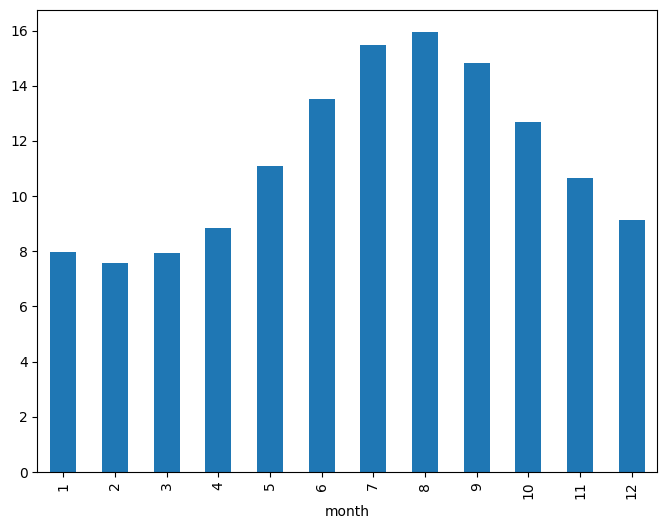

In [374]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
group_months.AverageTemperature.plot(ax = ax, kind='bar')

**Graphique des moyennes des températures par mois pour les autres villes de France**

In [376]:
df_france_ok = df_france_dt.copy()
print("Nb Cities in France: ", len(df_france_ok.City.unique()))
df_france_ok.City.unique()

Nb Cities in France:  36


array(['Aix En Provence', 'Amiens', 'Angers', 'Besançon', 'Bordeaux',
       'Boulogne Billancourt', 'Brest', 'Caen', 'Clermont Ferrand',
       'Dijon', 'Grenoble', 'Le Havre', 'Le Mans', 'Lille', 'Limoges',
       'Lyon', 'Marseille', 'Metz', 'Montpellier', 'Mulhouse', 'Nîmes',
       'Nancy', 'Nantes', 'Nice', 'Orléans', 'Paris', 'Perpignan',
       'Reims', 'Rennes', 'Rouen', 'Saint Étienne', 'Strasbourg',
       'Toulon', 'Toulouse', 'Tours', 'Villeurbanne'], dtype=object)

Delta Brest : 16.24
Delta Marseille : 23.07
Delta Toulon : 23.07
Delta Caen : 23.89
Delta Le Havre : 23.89
Delta Rouen : 23.89
Delta Angers : 24.80
Delta Nantes : 24.80
Delta Rennes : 24.80
Delta Perpignan : 25.24
Delta Bordeaux : 25.34
Delta Limoges : 26.82
Delta Toulouse : 26.83
Delta Amiens : 27.14
Delta Boulogne Billancourt : 27.14
Delta Paris : 27.14
Delta Le Mans : 27.27
Delta Orléans : 27.27
Delta Tours : 27.27
Delta Aix En Provence : 27.86
Delta Montpellier : 27.86
Delta Nîmes : 27.86
Delta Clermont Ferrand : 28.20
Delta Saint Étienne : 28.20
Delta Lille : 28.22
Delta Nice : 28.40
Delta Grenoble : 29.17
Delta Lyon : 29.17
Delta Villeurbanne : 29.17
Delta Reims : 30.01
Delta Besançon : 30.30
Delta Dijon : 30.30
Delta Mulhouse : 30.45
Delta Metz : 31.40
Delta Nancy : 31.40
Delta Strasbourg : 31.40


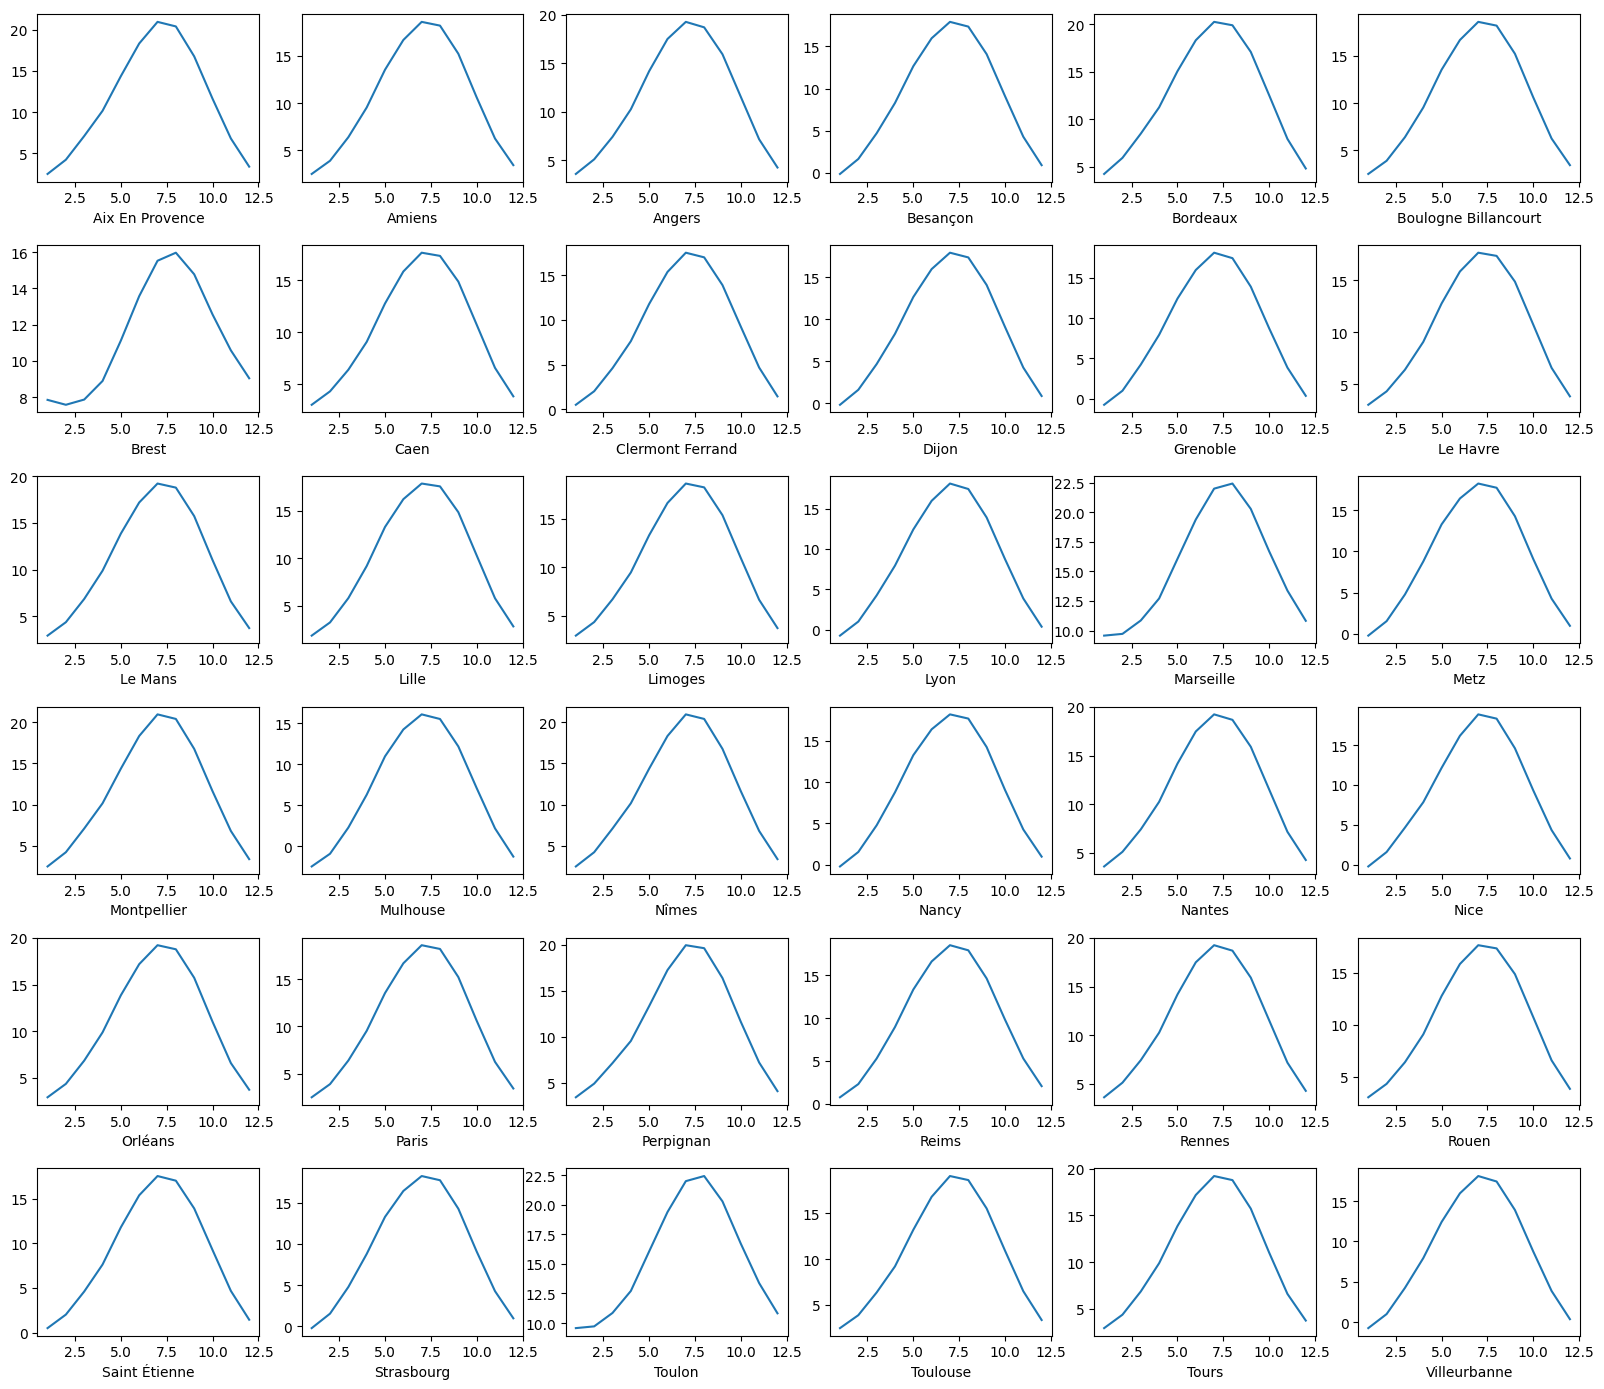

In [378]:
lst_cities = df_france_ok.City.unique()
fig, ax = plt.subplots(6, 6, figsize=(16, 14))
delta = []

for i in range(36):
    city = lst_cities[i]
    df_temp = df_france_ok[df_france_ok['City'] == city]
    df_temp = df_temp.rename({'month' : city}, axis = 'columns')
    group_months = df_temp.groupby([city]).agg({'AverageTemperature' : 'mean'})
    group_months.AverageTemperature.plot(subplots=True, x = range(2, 14), ax = ax[i // 6, i % 6], kind='line')
    delta.append((city, np.max(df_temp['AverageTemperature'].values) - np.min(df_temp['AverageTemperature'].values)))

fig.tight_layout()

delta.sort(key = lambda x : x[1])
for (city, d) in delta:
    print(f"Delta {city} : {d:.2f}")

### **Idem sur le même graphique**

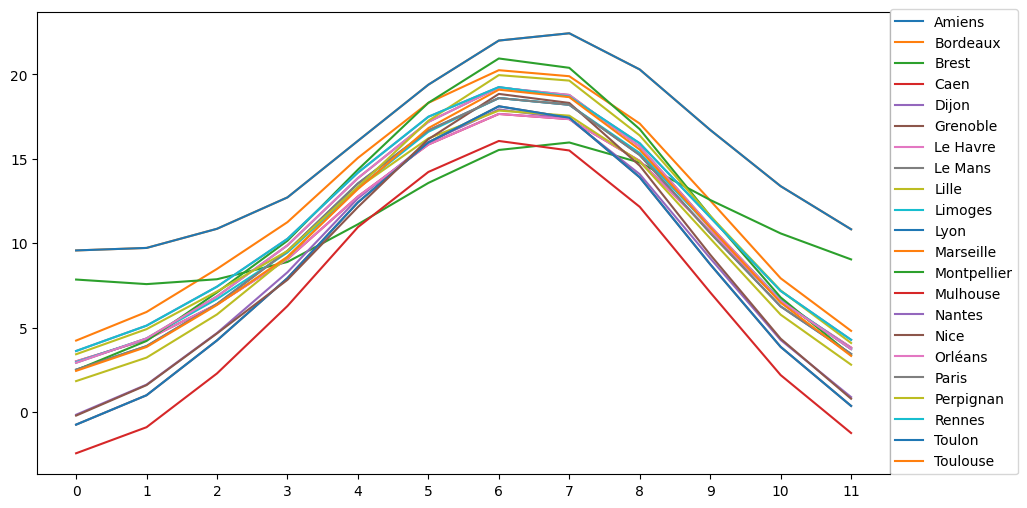

In [379]:
fig, plt.figure(figsize = (11, 6))

lst_cities2 = ['Amiens', 'Bordeaux', 'Brest', 'Caen', 'Dijon', 'Grenoble', 'Le Havre', 'Le Mans', 'Lille', 'Limoges', 'Lyon', 'Marseille',\
               'Montpellier', 'Mulhouse', 'Nantes', 'Nice', 'Orléans', 'Paris', 'Perpignan', 'Rennes', 'Toulon', 'Toulouse']

for city in lst_cities2:
    df1 = df_france_ok[df_france_ok['City'] == city]
    group1 = df1.groupby(['month']).agg({'AverageTemperature' : 'mean'})
    plt.plot(group1['AverageTemperature'].values, label=city)
plt.xticks(range(12))
plt.legend(loc=(1, 0))
plt.show()

### **Graphique des deltas de températures moyennes**

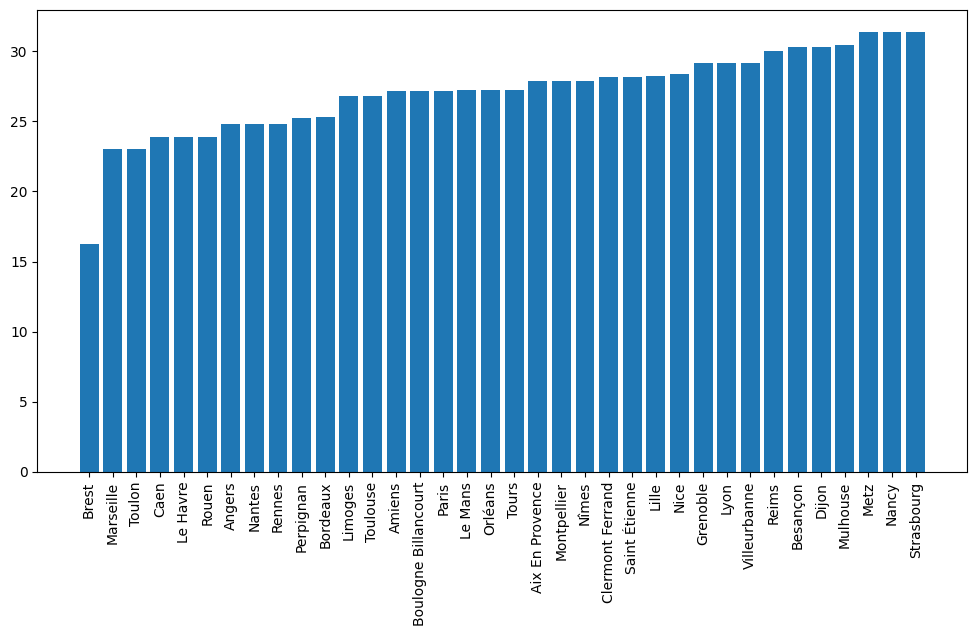

In [380]:
fig = plt.figure(figsize = (12, 6))
plt.bar([d[0] for d in delta], [d[1] for d in delta])
plt.xticks(rotation=90)
plt.show()

## **Code Pierre**

In [ ]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os

df = pd.read_csv("GlobalLandTemperaturesByCity.csv")

df_brest = df[df['City'] == 'Brest']
df_brest = df_brest[df_brest['Country'] == 'France']
df_brest["dt"] = pd.to_datetime(df_brest["dt"])
df_brest = df_brest.rename(columns={"dt": "Date"})
df_brest.set_index("Date", inplace=True)

df_brest = df_brest.drop(['AverageTemperatureUncertainty', 'City', 'Country','Latitude','Longitude'], axis=1)

def chronologie(i):
    plt.figure(figsize=(28, 4))
    plot = df_brest["AverageTemperature"][i:i+300].plot(kind='line', title="Série temporelle des températures brestoises")
    plt.savefig(f"images/brest{i}.jpg", format='jpg', dpi=75)
    plt.close()
    images.append(Image.open(f"images/brest{i}.jpg"))

images = []
for i in range(0,3180,15):
    chronologie(i)
images[0].save("animation.gif", save_all=True, append_images=images[1:], duration=150, loop=0)

### **Quels sont les mois outliers pour la ville de Brest**

#### **1ère méthode 2xSigma (BAD)**

In [381]:
describe = df_ok[df_ok.columns[:1]].describe()
describe

,AverageTemperature
count,2564.000000
mean,11.305206
std,3.199729
min,2.634000
25%,8.695250
50%,10.936500
75%,14.131500
max,18.871000


In [382]:
avg = describe.loc['mean', 'AverageTemperature'].item(0)
std = describe.loc['std', 'AverageTemperature'].item(0)
print("Moyenne    :", avg)
print("Ecart-type :", std)

Moyenne    : 11.30520592823713
Ecart-type : 3.199728930632086


In [ ]:
# Remove outliers with 2 sigmas method
# IT IS NOT ACCURATE AND IT MAKES GAPS IN THE DATA => VERY BAD

print(df_ok.shape)
lowerbound, upperbound = avg - 2.0 * std, avg + 2.0 * std

df_w_outliers = df_ok[(df_ok['AverageTemperature'] < upperbound) &
                      (df_ok['AverageTemperature'] > lowerbound)]

print(f"Remove {df_ok.shape[0] - df_w_outliers.shape[0]} outliers")
df_w_outliers

(2564, 4)
Remove 5 outliers


,AverageTemperature,AverageTemperatureUncertainty,month,year
dt,,,,
1800-01-01,8.654,2.211,1,1800
1800-02-01,6.434,4.853,2,1800
1800-03-01,6.821,4.320,3,1800
1800-04-01,10.056,2.346,4,1800
1800-05-01,11.919,1.582,5,1800
...,...,...,...,...
2013-04-01,8.664,0.659,4,2013
2013-05-01,10.140,0.491,5,2013
2013-06-01,13.187,0.563,6,2013


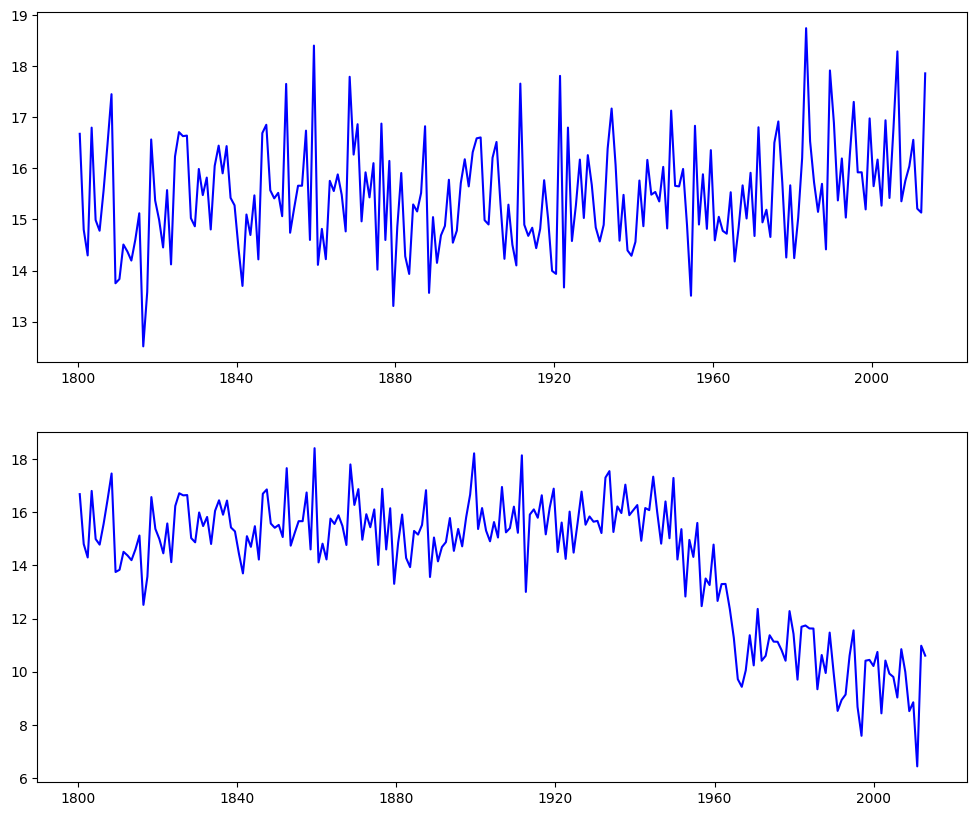

In [ ]:
start_point = 6 # = July
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 10))

ax1.plot(df_ok[start_point::12].index, df_ok[start_point::12]["AverageTemperature"], label="Train", color="Blue")
ax2.plot(df_w_outliers[start_point::12].index, df_w_outliers[start_point::12]["AverageTemperature"], label="Train", color="Blue")
plt.show()

#### **2ème méthode**

In [406]:
dict_months = dict(zip(range(12), ['janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août', 'septembre', 'octobre', 'novembre', 'décembre']))

for i in range(12):
    df_temp = df_ok[df_ok['month'] == i+1]
    print(f"Mois {dict_months[i]}")
    describe = df_temp.describe()
    avg = describe.loc['mean', 'AverageTemperature'].item(0)
    std = describe.loc['std', 'AverageTemperature'].item(0)
    print("Moyenne    :", avg)
    print("Ecart-type :", std)

    # Replace the extremal values
    lowerbound, upperbound = avg - 2.0 * std, avg + 2.0 * std

    df_w_outliers = df_ok[(df_ok['AverageTemperature'] < upperbound) &
                        (df_ok['AverageTemperature'] > lowerbound)]

    print(f"Remove {df_ok.shape[0] - df_w_outliers.shape[0]} outliers")
    

Mois janvier
Moyenne    : 7.965714953271027
Ecart-type : 1.5924509995514882
Remove 1250 outliers
Mois février
Moyenne    : 7.571710280373832
Ecart-type : 1.560220882456533
Remove 1358 outliers
Mois mars
Moyenne    : 7.932710280373831
Ecart-type : 1.2296579509082377
Remove 1467 outliers
Mois avril
Moyenne    : 8.859070093457943
Ecart-type : 1.00992921229321
Remove 1468 outliers
Mois mai
Moyenne    : 11.078953271028038
Ecart-type : 0.9994912826519455
Remove 1623 outliers
Mois juin
Moyenne    : 13.506752336448598
Ecart-type : 0.9225963412009244
Remove 1762 outliers
Mois juillet
Moyenne    : 15.480126168224299
Ecart-type : 1.0438818660193439
Remove 1801 outliers
Mois août
Moyenne    : 15.947612149532707
Ecart-type : 0.9909490467148293
Remove 1905 outliers
Mois septembre
Moyenne    : 14.823483568075117
Ecart-type : 1.0064628544179153
Remove 1701 outliers
Mois octobre
Moyenne    : 12.69361502347418
Ecart-type : 1.141473002416145
Remove 1575 outliers
Mois novembre
Moyenne    : 10.670934272300

**A terminer ...**

## **Modèles statistiques**

https://medium.com/@kylejones_47003/time-series-analysis-with-statsmodels-in-python-ea0fce203c0a

### **Séparation des données**

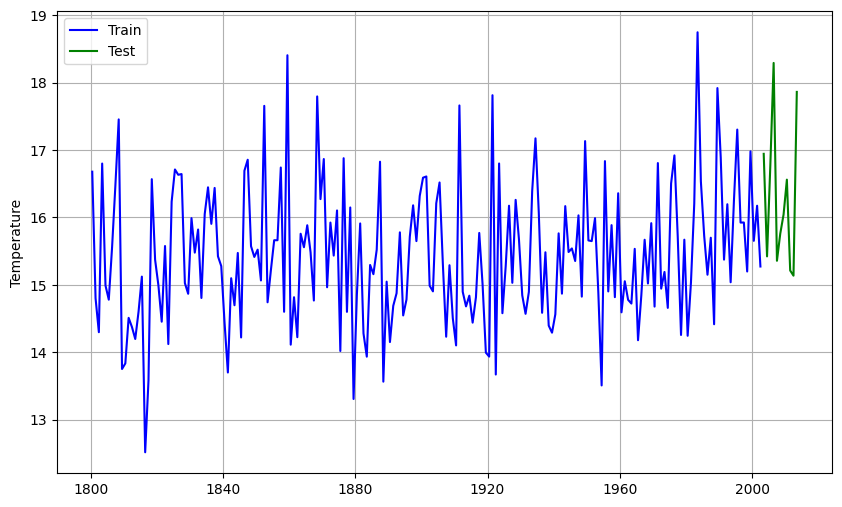

In [417]:
df_train = df_ok[df_ok['year'] < 2003]
df_test  = df_ok[df_ok['year'] >= 2003]

start_point = 6
# Plot the Data
plt.figure(figsize=(10, 6))
plt.plot(df_train[start_point::12].index, df_train[start_point::12]["AverageTemperature"], label="Train", color="Blue")
plt.plot(df_test[start_point::12].index, df_test[start_point::12]["AverageTemperature"], label="Test", color="Green")

plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()

### **Etude des données**

Décomposition de la série temporelle pour un mois en : 
- Moyenne
- Tendance
- Seasonnalité
- Bruit

Un critère important en estimation de modèle est la distribution du résidu. Celui-ci ne doit pas être corrélé car le contraire indiquerait que cette erreur pourrait être prise en compte dans le modèle.

| Observation     | Attendu                |
|------|----------------------|
| Valeur du résidu  | Pas de tendance ou de périodicité |
| Histogramme et KDE| L'histogramme et l'estimation de la densité doivent être proche d'une gaussienne |
| Normal Q-Q | La plupart des points sont sur la bissectrice |
| Correlogram | 95% des corrélations pour un lag supérieur à 1 ne sont pas significantes |

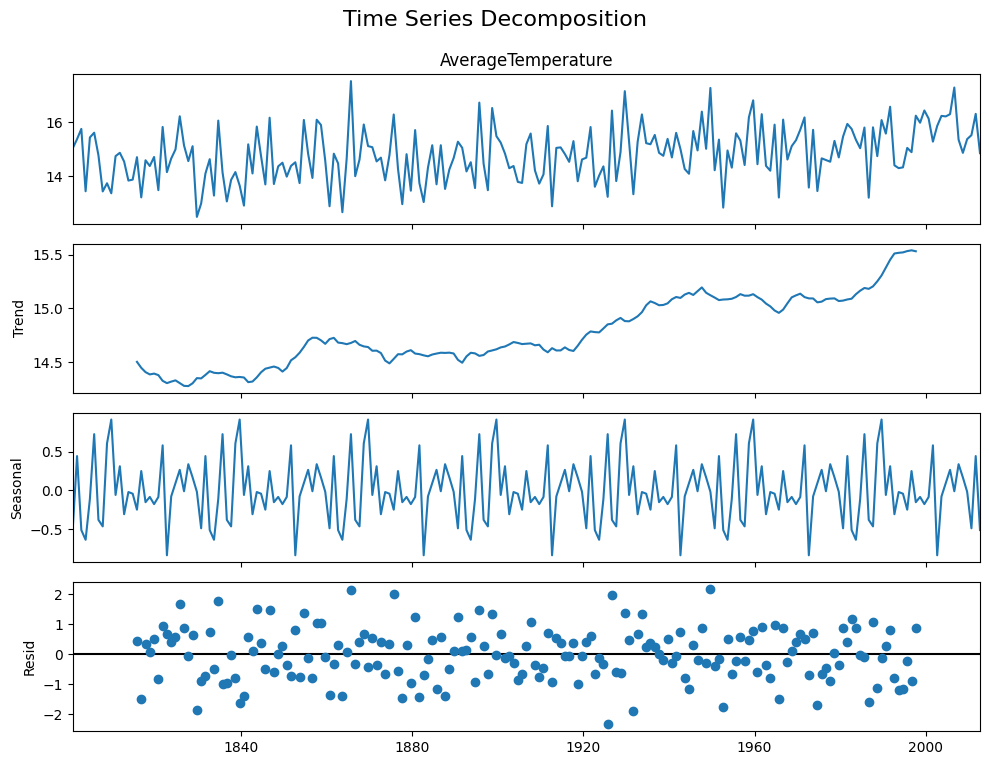

In [422]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(df_ok[8::12]["AverageTemperature"], model="additive", period=30)

# Plot the components
fig = decomposition.plot()
fig.set_size_inches(10, 8)  # Adjust the figure size
plt.suptitle("Time Series Decomposition", fontsize=16, y=0.95)  # Adjust title position
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Prevent overlap of title with subplots
plt.savefig("time_series_decomposition.png")
plt.show()

### **ARMA**

[statsmodels.org/ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html#statsmodels.tsa.arima.model.ARIMA)

Étant donné une série temporelle Xt, le modèle ARMA est un outil pour comprendre et prédire, éventuellement, les valeurs futures de cette série. Le modèle est composé de deux parties : une part autorégressive (AR) et une part moyenne-mobile (MA). Le modèle est généralement noté ARMA(p,q), où p est l'ordre de la partie AR et q l'ordre de la partie MA.


La partie autorégressive (AR) vise à prédire la valeur de notre série temporelle à l'instant t à l'aide des p instants précédents.

**Pour évaluer l'ordre p de la partie AR** :

La visualisation **PACF** faite précédemment nous a indiqué que p = 1.


La partie moyenne mobile (MA) vise à prédire la valeur à l'instant t à partir des erreurs des q derniers instants.<br>

**Pour évaluer l'ordre q de la partie MA** :

Question ouverte ???

**Remarque** :
Nos données sont réelles (pas crées artificiellement pour l'exercice) donc il est difficile de trouver les ordres par des lectures graphiques, on essaiera plutôt de faire une recherche manuelle (genre de gridsearch) et d'évaluer notre modèle à chaque fois.

In [492]:
from statsmodels.tsa.arima.model import ARIMA

# order = (p, d, q)
# p: order of AR
# q: order of MA
# d: nb of differenciations
# d = 0: ARMA, otherwise ARIMA

order = (1, 0, 2)
model = ARIMA(df_train['AverageTemperature'], order=order)
arma_result = model.fit()
print(arma_result.summary())

                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                 2436
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -4918.389
Date:                Tue, 11 Feb 2025   AIC                           9846.779
Time:                        18:16:12   BIC                           9875.769
Sample:                    01-01-1800   HQIC                          9857.317
                         - 12-01-2002                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.2592      0.158     71.176      0.000      10.949      11.569
ar.L1          0.6049      0.027     22.786      0.000       0.553       0.657
ma.L1          0.3257      0.028     11.568      0.0

#### **Visualisation**

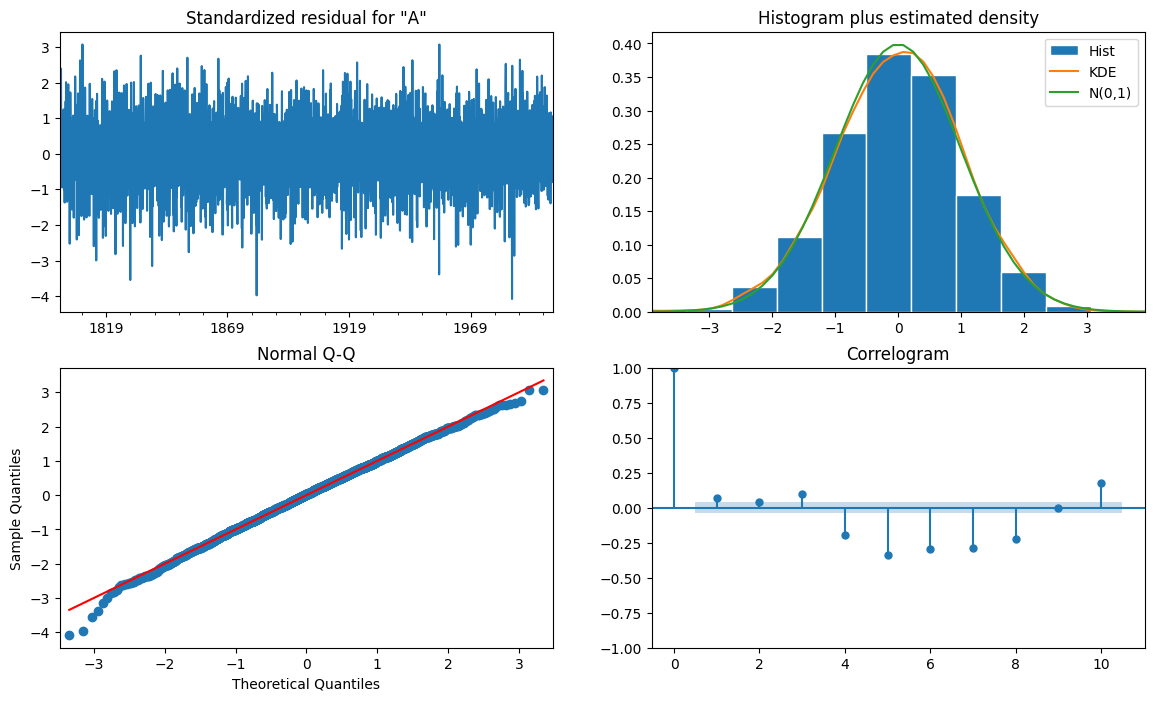

In [493]:
# Plot the residuals
arma_result.plot_diagnostics(figsize=(14, 8))
# Residual: Kind of difference between y_true y_pred on training data
plt.show()

#### **Evaluation du modèle**

https://medium.com/@kylejones_47003/time-series-analysis-with-statsmodels-in-python-ea0fce203c0a


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Test  Mean Absolute Error (MAE): 0.914
Test  Mean Absolute Percentage Error (MAPE): 7.951%
Test  Root Squared Error (RMSE): 1.155

Train Mean Absolute Error (MAE): 0.953
Train Mean Absolute Percentage Error (MAPE): 10.038%
Train Root Squared Error (RMSE): 1.217
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                 2436
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -3931.503
Date:                Tue, 11 Feb 2025   AIC                           7887.006
Time:                        18:18:11   BIC                           7956.583
Sample:                    01-01-1800   HQIC                          7912.299
                         - 12-01-2002                                         
Covariance Type:                  opg                                  

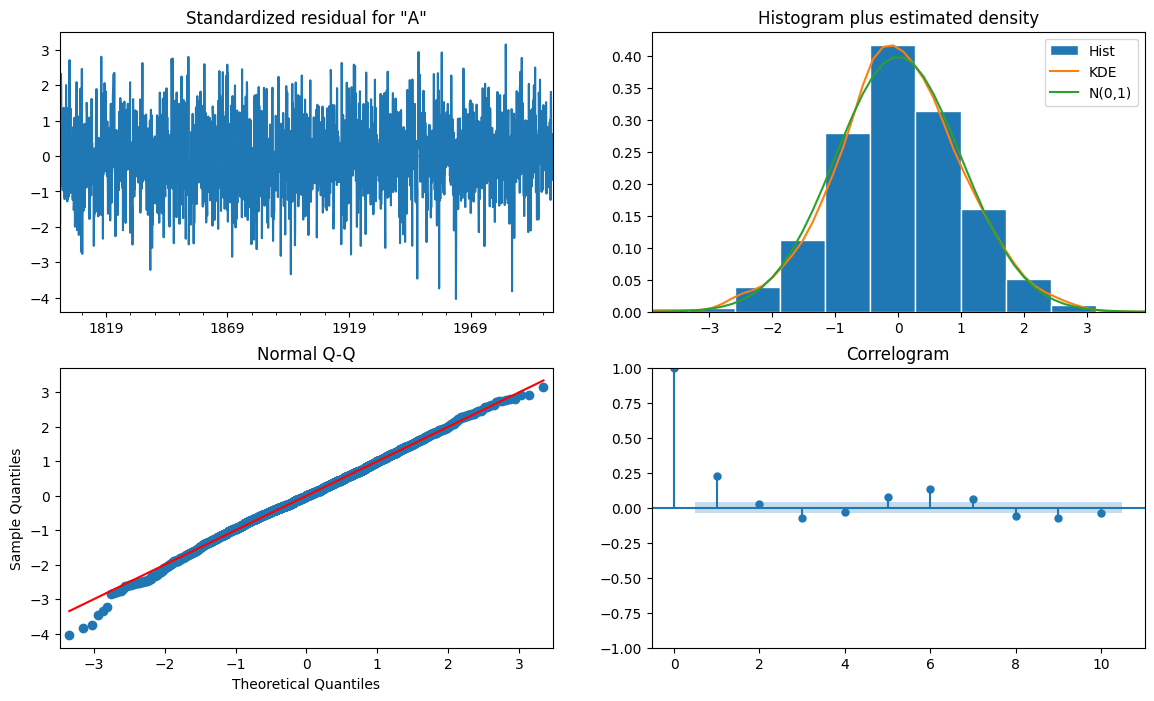

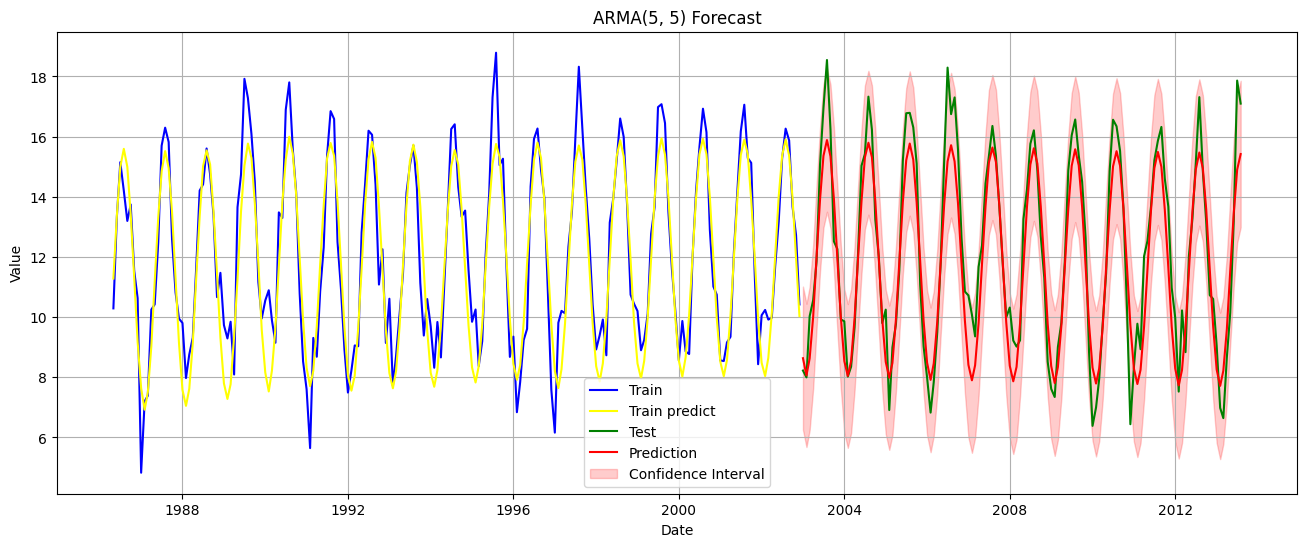

(0.9525873343718749,
 0.10037922689306551,
 1.2166279468513568,
 0.9144463957938995,
 0.07950788187377812,
 1.1553510072266604)

In [495]:
def result_ARIMA(p = 0, q = 0, d = 0, display = False):
    ''' Compute ARIMA(p, d, q) model '''

    model = ARIMA(df_train["AverageTemperature"], order=(p, d, q))
    arima_result = model.fit()

    # Forecast Future Values
    forecast = arima_result.get_forecast(steps=128)
    forecast_index = df_test.index  # Use the same index as the hold-out set
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    test_mae  = mean_absolute_error(df_test["AverageTemperature"], forecast_mean)
    test_mape = mean_absolute_percentage_error(df_test["AverageTemperature"], forecast_mean)
    test_rmse = root_mean_squared_error(df_test["AverageTemperature"], forecast_mean)

    print("\n*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*")
    print(f"Test  Mean Absolute Error (MAE): {test_mae:.3}")
    print(f"Test  Mean Absolute Percentage Error (MAPE): {test_mape:.3%}")
    print(f"Test  Root Squared Error (RMSE): {test_rmse:.3f}")

    # Prediction on training data
    pred = arima_result.predict()
    train_mae  = mean_absolute_error(df_train["AverageTemperature"], pred)
    train_mape = mean_absolute_percentage_error(df_train["AverageTemperature"], pred)
    train_rmse = root_mean_squared_error(df_train["AverageTemperature"], pred)

    print(f"\nTrain Mean Absolute Error (MAE): {train_mae:.3}")
    print(f"Train Mean Absolute Percentage Error (MAPE): {train_mape:.3%}")
    print(f"Train Root Squared Error (RMSE): {train_rmse:.3f}")
    print("*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n")

    if display:
        print(arima_result.summary())

        arima_result.plot_diagnostics(figsize=(14, 8))
        
        plt.figure(figsize=(16, 6))
        plt.plot(df_train[-200:]["AverageTemperature"].index, df_train[-200:]["AverageTemperature"], label="Train", color="Blue")
        plt.plot(df_train[-200:]["AverageTemperature"].index, pred[-200:], label="Train predict", color="Yellow")
        plt.plot(df_test[:200]["AverageTemperature"].index, df_test[:200]["AverageTemperature"], label="Test", color="Green")
        plt.plot(forecast_index, forecast_mean, color="Red", label='Prediction')
        plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="Red", alpha=0.2, label="Confidence Interval")
        plt.title(f"ARMA({p}, {q}) Forecast")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.legend()
        plt.grid()
        plt.show()

    return train_mae, train_mape, train_rmse, test_mae, test_mape, test_rmse

result_ARIMA(5, 5, display = True)

### **Recherche des meilleurs paramètres** (Grid Search)

In [490]:
import itertools

range_p = range(0, 6)
range_q = range(0, 6)
range_pq = list(itertools.product(range_p, range_q))

mapes, rmses, maes = [], [], []

for param in range_pq:
    model = ARIMA(df_train["AverageTemperature"], order=(param[0], 0, param[1]))
    arima_result = model.fit()

    # Forecast Future Values for Hold-Out Period
    forecast = arima_result.get_forecast(steps=128)
    forecast_index = df_test.index  # Use the same index as the hold-out set
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Calculate MAPE on Hold-Out Set
    mae = mean_absolute_error(df_test["AverageTemperature"], forecast_mean)
    mape = mean_absolute_percentage_error(df_test["AverageTemperature"], forecast_mean)
    rmse = root_mean_squared_error(df_test["AverageTemperature"], forecast_mean)

    # print('ARMA: {} '.format(param))
    # print(f"\nMean Absolute Percentage Error (MAPE): {mape:.3%}")
    # print(f"Root Squared Error (RMSE): {rmse:.3f}")
    maes.append(mae)
    mapes.append(mape)
    rmses.append(rmse)

In [496]:
lst = list(zip(range_pq, mapes, rmses, maes))

for i, pq in enumerate(range_pq):
    print(f'Param {pq}\tMAPE: {mapes[i]:.3%}\t\tRMSE: {rmses[i]:.3f}\t\tMAE: {maes[i]:.3f}')

print()

Param (0, 0)	MAPE: 24.077%		RMSE: 3.353		MAE: 2.854
Param (0, 1)	MAPE: 23.977%		RMSE: 3.347		MAE: 2.846
Param (0, 2)	MAPE: 23.921%		RMSE: 3.343		MAE: 2.842
Param (0, 3)	MAPE: 23.874%		RMSE: 3.341		MAE: 2.837
Param (0, 4)	MAPE: 23.784%		RMSE: 3.338		MAE: 2.829
Param (0, 5)	MAPE: 23.772%		RMSE: 3.337		MAE: 2.828
Param (1, 0)	MAPE: 23.946%		RMSE: 3.352		MAE: 2.846
Param (1, 1)	MAPE: 23.866%		RMSE: 3.346		MAE: 2.839
Param (1, 2)	MAPE: 23.842%		RMSE: 3.343		MAE: 2.836
Param (1, 3)	MAPE: 23.781%		RMSE: 3.361		MAE: 2.839
Param (1, 4)	MAPE: 23.824%		RMSE: 3.362		MAE: 2.844
Param (1, 5)	MAPE: 23.824%		RMSE: 3.358		MAE: 2.844
Param (2, 0)	MAPE: 23.683%		RMSE: 3.329		MAE: 2.819
Param (2, 1)	MAPE: 22.248%		RMSE: 3.147		MAE: 2.652
Param (2, 2)	MAPE: 9.490%		RMSE: 1.400		MAE: 1.130
Param (2, 3)	MAPE: 9.601%		RMSE: 1.414		MAE: 1.148
Param (2, 4)	MAPE: 9.478%		RMSE: 1.424		MAE: 1.155
Param (2, 5)	MAPE: 9.654%		RMSE: 1.420		MAE: 1.152
Param (3, 0)	MAPE: 23.133%		RMSE: 3.258		MAE: 2.753
Param (3, 1)	MAP